### Aerial Cactus Identification

## Loading required libraries

In [1]:
import numpy as np
import pandas as pd

from fastai.utils import *
from fastai.vision import *
from fastai.callbacks import *
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os
print(os.listdir("../input"))

['train', 'test', 'train.csv', 'sample_submission.csv']


In [2]:
!pip install -q efficientnet_pytorch

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from efficientnet_pytorch import EfficientNet

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [5]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


In [6]:
hack_path = Path('../input')

## Load train and test dataframes

In [7]:
train_df = pd.read_csv(hack_path/'train.csv')
test_df = pd.read_csv(hack_path/'sample_submission.csv')

In [8]:
def get_data(bs, size):
    data = ImageDataBunch.from_df(df=train_df, path=hack_path/'train', folder='train',
                                  bs=bs, size=size, valid_pct=0.1, 
                                  resize_method=ResizeMethod.SQUISH, 
                                  ds_tfms=get_transforms(do_flip=True, flip_vert=True,
                                                         max_lighting=0.2, max_zoom=1.1, 
                                                         max_warp=0.2, max_rotate=10))
    test_data = ImageList.from_df(test_df, path=hack_path/'test', folder='test')
    data.add_test(test_data)
    data.normalize(imagenet_stats)
    return data

In [9]:
data = get_data(bs=64, size=128)

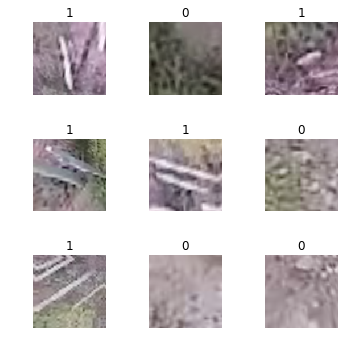

In [10]:
data.show_batch(rows=3, figsize=(5,5))

## Efficientnet-B3 Model

In [11]:
model_name = 'efficientnet-b3'

In [12]:
def get_model(pretrained=True, **kwargs):
    model = EfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(model._fc.in_features, data.c)
    return model

In [13]:
learn = Learner(data, get_model(), 
                metrics=[AUROC(), FBeta(), accuracy],
                callback_fns=[partial(SaveModelCallback)],
                wd=0.1,
                path = '.')

Downloading: "http://storage.googleapis.com/public-models/efficientnet-b3-c8376fa2.pth" to /tmp/.torch/models/efficientnet-b3-c8376fa2.pth
49380963it [00:00, 131855680.22it/s]


Loaded pretrained weights for efficientnet-b3


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03


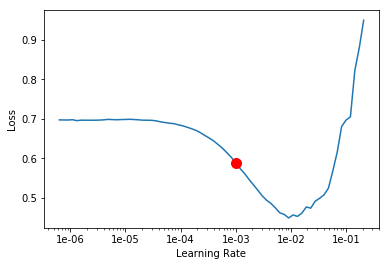

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [15]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.001

In [16]:
learn.fit_one_cycle(10, slice(min_grad_lr))

epoch,train_loss,valid_loss,auroc,f_beta,accuracy,time
0,0.038682,0.030170,0.999761,0.994063,0.993143,01:12
1,0.023538,0.007597,0.999979,0.999392,0.997714,01:10
2,0.021638,0.020021,0.999783,0.997872,0.995429,01:10
3,0.011923,0.015577,0.999970,0.997571,0.992571,01:10
4,0.007995,0.001544,1.000000,1.000000,1.000000,01:09
5,0.007650,0.002368,1.000000,0.999696,0.998857,01:09
6,0.002293,0.001107,1.000000,0.999848,0.999429,01:09
7,0.002068,0.000154,1.000000,1.000000,1.000000,01:09
8,0.000166,0.000329,1.000000,1.000000,1.000000,01:09
9,0.000148,0.000127,1.000000,1.000000,1.000000,01:09


Better model found at epoch 0 with val_loss value: 0.03016997128725052.
Better model found at epoch 1 with val_loss value: 0.007596930023282766.
Better model found at epoch 4 with val_loss value: 0.001543851220048964.
Better model found at epoch 6 with val_loss value: 0.0011070123873651028.
Better model found at epoch 7 with val_loss value: 0.00015358450764324516.
Better model found at epoch 9 with val_loss value: 0.00012708180292975157.


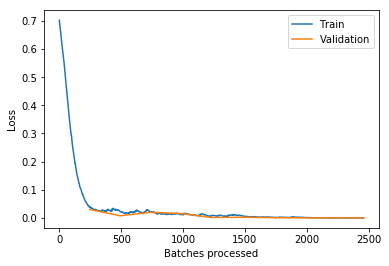

In [17]:
learn.recorder.plot_losses()

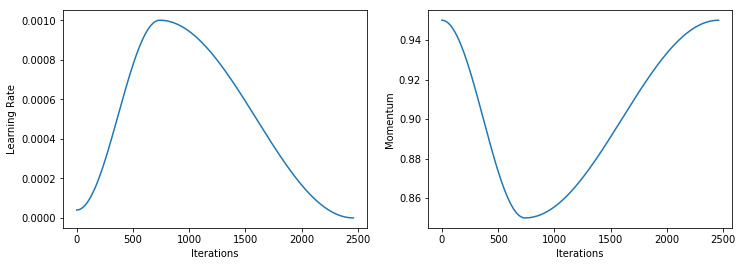

In [18]:
learn.recorder.plot_lr(show_moms=True)

In [19]:
validation = learn.validate()
print("Final model validation loss: {0}".format(validation[0]))

Final model validation loss: 0.00012708180292975157


In [20]:
learn.save('efficientnet-cactus', return_path=True)

PosixPath('models/efficientnet-cactus.pth')

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

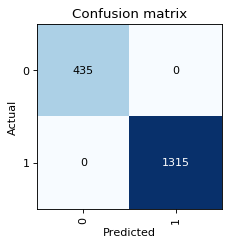

In [22]:
interp.plot_confusion_matrix(figsize=(3,3), dpi=80)

In [23]:
interp.most_confused(min_val=2)

[]

## Getting predictions

In [24]:
probability, _ = learn.TTA(ds_type=DatasetType.Test)

In [25]:
probability.argmin(dim=1)[:10]

tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 1])

In [26]:
probability.numpy()[:, 0]

array([1.708166e-05, 5.038176e-05, 9.999999e-01, 9.999996e-01, ..., 1.883190e-06, 1.686904e-06, 1.079087e-05,
       6.538143e-05], dtype=float32)

In [27]:
test_df.has_cactus = probability.numpy()[:, 0]

In [28]:
test_df.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.000017
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.000050
2,001ee6d8564003107853118ab87df407.jpg,1.000000
3,002e175c3c1e060769475f52182583d0.jpg,1.000000
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.000816


In [29]:
test_df.to_csv('submission.csv', index=False)

**fin**